In [ ]:
import numpy as np
import scipy


In [ ]:

class Controller:
    def __init__(self, horizon, dt, distance_threshold, dist_coef, lin_speed_coef, ang_speed_coef, speed_coef, dyaw_coef=1.0):
        self.horizon = horizon
        self.dt = dt
        self.distance_threshold = distance_threshold
        self.dist_coef = dist_coef
        self.lin_speed_coef = lin_speed_coef
        self.ang_speed_coef = ang_speed_coef
        self.speed_coef = speed_coef
        self.dyaw_coef = dyaw_coef

        self.x0 = np.array([0.0] * (2 * self.horizon))
        self.bounds = list()
        for _ in range(self.horizon):
            self.bounds += [[0.0, 0.50]]
            self.bounds += [[-0.10, 0.10]]

    def step(self, pos, yaw, linear_speed, angular_speed, dt):
        # a = (last_speed - linear_speed)
        x, y = pos
        x = x + linear_speed * np.math.cos(yaw) * dt
        y = y + linear_speed * np.math.sin(yaw) * dt
        yaw = yaw + angular_speed * dt
        return [x, y], yaw

    def cost_function(self, u, path):
        cur_pos = [initial_pos[0], initial_pos[1]]
        cur_yaw = yaw

        fv = 0
        lv, lw = linear_speed, 0.0
        du = 0.0
        dyaw = 0.0

        cost = 0.0

        for i in range(self.horizon):
            v, w = u[i*2], u[(i) * 2 + 1]
            cur_pos, cur_yaw = self.step(cur_pos, cur_yaw, v, w, self.dt)
            fv = v
            if lv is not None:
                du = self.lin_speed_coef * ((lv - v) ** 2) + self.ang_speed_coef * ((lw - w) ** 2)
            # dyaw += 
            lv = v
            lw = w

            cost += (cur_pos[0] - target_point[0]) ** 2 + (cur_pos[1] - target_point[1]) ** 2
            # cost += du
            # cost += (v - target_speed) ** 2
            
            if self.distance_btw(cur_pos, target_point) < self.distance_threshold:
                break

        # print("Control: {0}, cost: {1}, end pos: {2}".format(
        #     u,
        #     self.dist_coef * self.distance_btw(cur_pos, target_point) + \
        #         du + \
        #         self.speed_coef * np.math.fabs(fv - target_speed),
        #     cur_pos
        # ))
        # print("Start: {0}, end: {1}, target:{2}, dist to: {3}, cost: {4}".format(
        #     initial_pos,
        #     cur_pos,
        #     target_point, 
        #     self.distance_btw(cur_pos, target_point),
        #     self.dist_coef * self.distance_btw(cur_pos, target_point) + \
        #         du + self.speed_coef * np.math.fabs(fv - target_speed)
        # ))

        return cost

    def distance_btw(self, cur_pos, target_point):
        p1 = np.array(cur_pos)
        p2 = np.array(target_point)
        return np.linalg.norm(p1 - p2)

    def angle_btw_points(self, p1, p2):
        return np.math.atan2(p2[1] - p1[1], p2[0] - p1[0])

    def calc_control(self, initial_pos, target_point, yaw, linear_speed, target_speed):
        # self.x0[0] = linear_speed
        # self.x0[1] = angular_speed

        self.x0 = np.delete(self.x0, 0)
        self.x0 = np.delete(self.x0, 0)
        self.x0 = np.append(self.x0, self.x0[-2])
        self.x0 = np.append(self.x0, self.x0[-2])

        solution = optimize.minimize(self.cost_function, 
                                     x0=self.x0,  
                                     bounds=self.bounds, 
                                     args=(initial_pos, target_point, yaw, linear_speed, target_speed),
                                     method='SLSQP',
                                     tol = 1e-8)#,
                                    #  options = {'disp': True})
        if solution.success:
            # print(solution.x)
            self.x0 = solution.x
            return solution.x[:2]

        return None

In [22]:
import jax

Exception: Config option experimental_cpp_jit already defined

In [ ]:
def objective(x):
    return x[0]*x[3]*np.sum(x[:3]) + x[2]
def eq_constraints(x):
    return np.sum(x**2) - 40
def ineq_constrains(x):
    return np.prod(x) - 25

In [ ]:
# jit the functions
obj_jit = jit(objective)
con_eq_jit = jit(eq_constraints)
con_ineq_jit = jit(ineq_constrains)
# build the derivatives and jit them
obj_grad = jit(grad(obj_jit)) # objective gradient
obj_hess = jit(jacrev(jacfwd(obj_jit))) # objective hessian
con_eq_jac = jit(jacfwd(con_eq_jit)) # jacobian
con_ineq_jac = jit(jacfwd(con_ineq_jit)) # jacobian
con_eq_hess = jacrev(jacfwd(con_eq_jit)) # hessian
con_eq_hessvp = jit(lambda x, v: con_eq_hess(x) * v[0]) # hessian vector-product
con_ineq_hess = jacrev(jacfwd(con_ineq_jit)) # hessian
con_ineq_hessvp = jit(lambda x, v: con_ineq_hess(x) * v[0]) # hessian vector-product

# constraints
cons = [{'type': 'eq', 'fun': con_eq_jit, 'jac': con_eq_jac, 'hess': con_eq_hess},
{'type': 'ineq', 'fun': con_ineq_jit, 'jac': con_ineq_jac, 'hess': con_ineq_hess}]
# starting point
x0 = np.array([1, 5, 5, 1])
# variable bounds: 1 <= x[i] <= 5
bnds = [(1, 5) for _ in range(x0.size)]
# executing the solver
res = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess,

In [6]:
m = np.array([
        1.0, 2.0
    ])
m.T.dot(m)

5.0

In [3]:
x0 = [[2, 0], [2.0, 0.4], [0.4, 0.4], [0.4, 4.6], [4.6, 4.6]]
big_x0 = list()
for i in range(1, len(x0)):
    p1 = np.array(x0[i-1])
    p2 = np.array(x0[i])
    ds = np.linalg.norm(p1-p2)

    s = np.linspace(p1, p2, num=int(ds / 0.1))
    big_x0.extend(s.tolist())
x0 = np.array(big_x0)

In [9]:
import numpy as np
from scipy import optimize

# x0 = np.array([1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 6.0, 5.0, 7.0, 3.0])
# x0 = np.array([ [  0.  ,   0.  ],[  0.3 ,   0.  ],[  1.25,  -0.1 ],
#               [  2.1 ,  -0.9 ],[  2.85,  -2.3 ],[  3.8 ,  -3.95],
#               [  5.  ,  -5.75],[  6.4 ,  -7.8 ],[  8.05,  -9.9 ],
#               [  9.9 , -11.6 ],[ 12.05, -12.85],[ 14.25, -13.7 ],
#               [ 16.5 , -13.8 ],[ 19.25, -13.35],[ 21.3 , -12.2 ],
#               [ 22.8 , -10.5 ],[ 23.55,  -8.15],[ 22.95,  -6.1 ],
#               [ 21.35,  -3.95],[ 19.1 ,  -1.9 ]])
x0 = x0.reshape((-1))

print(x0)




def calc_curvatire(x):
    dx_dt = np.gradient(x[:, 0])
    dy_dt = np.gradient(x[:, 1])
    # velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    return curvature


def objective(x, x0):
    cost = 0
    curvature = calc_curvatire(x.reshape(-1, 2))

    l = len(x)

    x_0 = np.array([x[0], x[1]])
    x0_0 = np.array([x0[0], x0[1]])

    x_last = np.array([x[l - 2], x[l - 1]])
    x0_last = np.array([x0[l - 2], x0[l - 1]])

    cost += 100 * (x_0 - x0_0).T.dot(x_0 - x0_0)
    cost += 100 * (x_last - x0_last).T.dot(x_last - x0_last)

    for i in range(1, int(len(x) / 2) - 1):
        x_i = np.array([x[2*i], x[2*i + 1]])
        x_1i = np.array([x[2*(i-1)], x[2*(i-1) + 1]])
        x_i1 = np.array([x[2*(i+1)], x[2*(i+1) + 1]])

        d = x_i - (x_1i + x_i1) / 2.0

        x0_i = np.array([
            x0[2*i],
            x0[2*i + 1]
        ])

        cost += 0.1 * (x0_i - x_i).T.dot(x0_i - x_i)
        cost += d.T.dot(d)
        if curvature[i] > 0.3:
            cost += 10000000

    return cost


solution = optimize.minimize(objective, 
                             x0=x0, 
                             method='CG',
                             args=(x0,),
                            #  method='SLSQP',
                             tol=1e-8)#,
# solution = jax_minimize(objective, 
#                              x0=x0, 
#                              method='BFGS',
#                              args=(x0,),
#                             #  method='SLSQP',
#                              tol=1e-2)#,
print(solution.x)

[2.         0.         2.         0.13333333 2.         0.26666667
 2.         0.4        2.         0.4        1.89333333 0.4
 1.78666667 0.4        1.68       0.4        1.57333333 0.4
 1.46666667 0.4        1.36       0.4        1.25333333 0.4
 1.14666667 0.4        1.04       0.4        0.93333333 0.4
 0.82666667 0.4        0.72       0.4        0.61333333 0.4
 0.50666667 0.4        0.4        0.4        0.4        0.4
 0.4        0.505      0.4        0.61       0.4        0.715
 0.4        0.82       0.4        0.925      0.4        1.03
 0.4        1.135      0.4        1.24       0.4        1.345
 0.4        1.45       0.4        1.555      0.4        1.66
 0.4        1.765      0.4        1.87       0.4        1.975
 0.4        2.08       0.4        2.185      0.4        2.29
 0.4        2.395      0.4        2.5        0.4        2.605
 0.4        2.71       0.4        2.815      0.4        2.92
 0.4        3.025      0.4        3.13       0.4        3.235
 0.4        3.34   

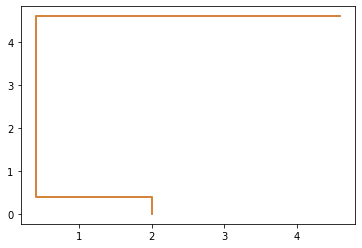

In [10]:

import matplotlib.pyplot as plt
%matplotlib inline 

_x, _y = list(), list()

for i in range(int(len(x0) / 2)):
    _x.append(x0[i*2])
    _y.append(x0[i*2 + 1])

plt.plot(_x, _y)

_x, _y = list(), list()

for i in range(int(len(solution.x) / 2)):
    _x.append(solution.x[i*2])
    _y.append(solution.x[i*2 + 1])

plt.plot(_x, _y)
plt.show()

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

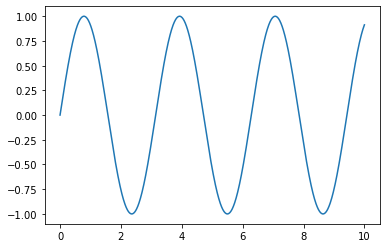

In [6]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

In [8]:
from jax.scipy.optimize import minimize as jax_minimize

In [17]:
a = np.array([ [  0.  ,   0.  ],[  0.3 ,   0.  ],[  1.25,  -0.1 ],
              [  2.1 ,  -0.9 ],[  2.85,  -2.3 ],[  3.8 ,  -3.95],
              [  5.  ,  -5.75],[  6.4 ,  -7.8 ],[  8.05,  -9.9 ],
              [  9.9 , -11.6 ],[ 12.05, -12.85],[ 14.25, -13.7 ],
              [ 16.5 , -13.8 ],[ 19.25, -13.35],[ 21.3 , -12.2 ],
              [ 22.8 , -10.5 ],[ 23.55,  -8.15],[ 22.95,  -6.1 ],
              [ 21.35,  -3.95],[ 19.1 ,  -1.9 ]])
a = np.array([2.00010124e+00, 1.65929338e-04, 2.01153957e+00, 1.30831527e-01,
 1.97325609e+00, 2.63169489e-01, 2.01866021e+00, 4.32629455e-01,
 2.03222004e+00, 3.91941808e-01, 1.86225321e+00, 3.76343408e-01,
 1.78388442e+00 ,4.04446129e-01, 1.67875740e+00, 3.91548370e-01,
 1.57345377e+00, 4.07165320e-01, 1.46630348e+00, 3.99805724e-01,
 1.35982458e+00, 4.01804618e-01, 1.25305364e+00, 4.01910206e-01,
 1.14668173e+00, 3.98237733e-01, 1.04000000e+00, 4.00000005e-01,
 9.33333334e-01, 3.99999995e-01, 8.26666667e-01, 3.99999999e-01,
 7.20000000e-01, 4.00000001e-01, 6.13333333e-01, 4.00000000e-01,
 5.06671575e-01, 4.00000000e-01, 4.00004894e-01, 4.00000000e-01])

a = a.reshape((-1, 2))
dx_dt = np.gradient(a[:, 0], edge_order=1)
dy_dt = np.gradient(a[:, 1],  edge_order=2)
velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

d2s_dt2 = np.gradient(ds_dt)
d2x_dt2 = np.gradient(dx_dt)
d2y_dt2 = np.gradient(dy_dt)

curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
print(a[:, 0], 1 / 5.0)
print(dx_dt, 1 / 5.0)
print(d2x_dt2, 1 / 5.0)

[2.00010124 2.01153957 1.97325609 2.01866021 2.03222004 1.86225321
 1.78388442 1.6787574  1.57345377 1.46630348 1.35982458 1.25305364
 1.14668173 1.04       0.93333333 0.82666667 0.72       0.61333333
 0.50667158 0.40000489] 0.2
[ 0.01143833 -0.01342257  0.00356032  0.02948197 -0.0782035  -0.12416781
 -0.0917479  -0.10521532 -0.10622696 -0.1068146  -0.10662492 -0.10657142
 -0.10652682 -0.1066742  -0.10666667 -0.10666667 -0.10666667 -0.10666421
 -0.10666422 -0.10666668] 0.2
[-2.48609050e-02 -3.93900500e-03  2.14522750e-02 -4.08819100e-02
 -7.68248925e-02 -6.77220250e-03  9.47624250e-03 -7.23952750e-03
 -7.99635000e-04 -1.98980000e-04  1.21585000e-04  4.90500000e-05
 -5.13865000e-05 -6.99232500e-05  3.76550000e-06 -2.49999993e-10
  1.22725000e-06  1.22375000e-06 -1.23425000e-06 -2.46150000e-06] 0.2


In [61]:
print(a.shape)
l = a.reshape((40,))
l.reshape((-1, 2))

(20, 2)


array([[  0.  ,   0.  ],
       [  0.3 ,   0.  ],
       [  1.25,  -0.1 ],
       [  2.1 ,  -0.9 ],
       [  2.85,  -2.3 ],
       [  3.8 ,  -3.95],
       [  5.  ,  -5.75],
       [  6.4 ,  -7.8 ],
       [  8.05,  -9.9 ],
       [  9.9 , -11.6 ],
       [ 12.05, -12.85],
       [ 14.25, -13.7 ],
       [ 16.5 , -13.8 ],
       [ 19.25, -13.35],
       [ 21.3 , -12.2 ],
       [ 22.8 , -10.5 ],
       [ 23.55,  -8.15],
       [ 22.95,  -6.1 ],
       [ 21.35,  -3.95],
       [ 19.1 ,  -1.9 ]])

In [1]:
1 / 60

0.016666666666666666